<div style="background-color: #333; padding: 40px; border: 2px solid #ffd700; border-radius: 10px; color: #ffd700; text-align: center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">

<h1 style="font-size: 48px; font-weight: bold; color: #ffd700;">LLM Classification finetuning DeBERTA</h1>

<img src="https://cdn.arstechnica.net/wp-content/uploads/2023/12/GettyImages-152404829-scaled.jpg" alt="Chatbot arena" style="width: 500px; margin: 20px auto; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    
</div>

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">Table of content</div>

<ul class="list-group" id="list-tab" role="tablist">
    <li><a href="#0.-Introduction">0. Introduction</a></li><br>
    <li><a href="#1.-Import-Libraries">1. Import Libraries</a></li><br>
    <li><a href="#2.-Data-Loading-&-Inspection">2. Data Loading & Inspection</a></li><br>
    <li><a href="#3.-Text-Preprocessing">3. Text Preprocessing</a></li><br>
    <li><a href="#4.-Dataset-Preparation">4. Dataset Preparation</a></li><br>
    <li><a href="#5.-Model-Building">5. Model Building</a></li><br>
    <li><a href="#6.-Training-&-Evaluation">6. Training & Evaluation</a></li><br>
    <li><a href="#7.-Prediction-&-Submission">7. Prediction & Submission</a></li><br>
</ul>

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">0. Introduction</div>

### Intro : 

In the rapidly evolving world of large language models (LLMs), one of the most critical challenges is ensuring that AI-generated responses align with human preferences. While modern chatbots can produce fluent and coherent text, not all responses are equally engaging, helpful, or satisfying to users. This Kaggle competition tackles this challenge head-on by leveraging real-world data from Chatbot Arena, where users compare responses from different LLMs and choose their preferred one.

### Competition Overview :

The goal is to predict which LLM response a human judge will prefer in a head-to-head battle. Each conversation consists of:

A user prompt (the input given to the chatbots).

Two LLM-generated responses (anonymous models competing against each other).

A human preference label (indicating which response was preferred).

This task mirrors Reinforcement Learning from Human Feedback (RLHF), a key technique for aligning AI with human values. Successfully predicting preferences helps improve reward models, which are essential for training better chatbots.

### Key challenges :

1. Biases in Human Judgments

    * Position bias: Users may favor the first or second response due to ordering.

    * Verbosity bias: Longer responses might be preferred even if less accurate.

    * Self-enhancement bias: Models may subtly promote themselves.

2. Model Generalization

    * The test set (~25K samples) requires robust predictions beyond the training data (55K samples).

3. Interpretable Preference Modeling

    * Understanding why users prefer certain responses can guide better LLM fine-tuning.
  
### Why this matters :

Improving preference prediction models directly enhances:

* Chatbot training.

* User satisfaction (by aligning AI with human expectations).

* Fairness & robustness (reducing biases in AI judgments).

By competing in this challenge, we contribute to the future of human-aligned AI assistants—making them not just smarter, but also more attuned to what users truly want.

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">1. Import Libraries</div>

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

# Configure GPU memory growth (prevents OOM errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-07-30 16:34:54.528454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753893294.739411      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753893294.795930      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1
/device:GPU:0


I0000 00:00:1753893310.798472      19 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_nlp
from sklearn.model_selection import train_test_split
from keras import backend as K

# Configuration
MODEL_NAME = "deberta_v3_extra_small_en"
SEQUENCE_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 5e-6

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">2. Data Loading & Inspection</div>

In [3]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/train.csv")
test_df = pd.read_csv("/kaggle/input/llm-classification-finetuning/test.csv")

# Quick inspection
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (57477, 9)
Test shape: (3, 4)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [4]:
# Basic validation checks
def check_data(df, name):
    print(f"\n{name} Data Summary:")
    print("- Missing values:", df.isna().sum().sum())
    print("- Duplicates:", df.duplicated().sum())
    print("- Target distribution:")
    print(df[['winner_model_a', 'winner_model_b', 'winner_tie']].mean())


check_data(train_df, "Train")


Train Data Summary:
- Missing values: 0
- Duplicates: 0
- Target distribution:
winner_model_a    0.349079
winner_model_b    0.341911
winner_tie        0.309011
dtype: float64


## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">3. Text Preprocessing</div>

In [5]:
class TextPreprocessor:
    def __init__(self):
        self.tokenizer = keras_nlp.models.DebertaV3Tokenizer.from_preset(MODEL_NAME)
        
    def clean_text(self, text):
        """Normalize text for DeBERTa"""
        text = str(text)
        text = re.sub(r"\s+", " ", text)  # Collapse whitespace
        text = re.sub(r"[^\x00-\x7F]+", " ", text)  # Remove non-ASCII
        return text.strip()
    
    def create_input_pairs(self, row):
        """Format prompt-response pairs"""
        clean_prompt = self.clean_text(row['prompt'])
        return [
            f"Prompt: {clean_prompt} {self.tokenizer.sep_token} Response: {self.clean_text(row['response_a'])}",
            f"Prompt: {clean_prompt} {self.tokenizer.sep_token} Response: {self.clean_text(row['response_b'])}"
        ]

# Initialize processor
processor = TextPreprocessor()

I0000 00:00:1753893317.411958      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# Apply preprocessing
train_df['inputs'] = train_df.apply(processor.create_input_pairs, axis=1)
test_df['inputs'] = test_df.apply(processor.create_input_pairs, axis=1)

# Create labels (0: model_a wins, 1: model_b wins, 2: tie)
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)
train_df['label'] = train_df['label'].map({'winner_model_a':0, 'winner_model_b':1, 'winner_tie':2})

# Preview processed data
train_df[['inputs', 'label']].head()

,inputs,label
0,"[Prompt: [""Is it morally right to try to have ...",0
1,"[Prompt: [""What is the difference between marr...",1
2,"[Prompt: [""explain function calling. how would...",2
3,"[Prompt: [""How can I create a test set for a v...",0
4,"[Prompt: [""What is the best way to travel from...",1


## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">4. Dataset Preparation</div>

In [7]:
# Train/validation split
train_df, valid_df = train_test_split(
    train_df, 
    test_size=0.1, 
    stratify=train_df['label'],
    random_state=42
)

# Create TensorFlow datasets with proper input pair handling
def create_dataset(text_pairs, labels=None, preprocessor=None):
    """Convert to optimized TF Dataset with proper input pair handling"""
    AUTO = tf.data.AUTOTUNE
    
    # Convert to TensorFlow Dataset
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((text_pairs, labels))
        ds = ds.shuffle(1000)
    else:
        ds = tf.data.Dataset.from_tensor_slices(text_pairs)
    
    # Preprocessing function
    def preprocess_pair(text_pair, label=None):
        """Convert raw text pairs to model-ready format"""
        # Tokenize each response separately
        processed_a = preprocessor(text_pair[0])  # {'token_ids': ..., 'padding_mask': ...}
        processed_b = preprocessor(text_pair[1])
        
        # Stack to create (2, seq_len) tensors
        model_inputs = {
            "token_ids": tf.stack([processed_a["token_ids"], processed_b["token_ids"]], axis=0),
            "padding_mask": tf.stack([processed_a["padding_mask"], processed_b["padding_mask"]], axis=0)
        }
        return (model_inputs, label) if label is not None else model_inputs
    
    # Apply preprocessing and batching
    ds = ds.map(preprocess_pair, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

# Initialize preprocessor
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    MODEL_NAME,
    sequence_length=SEQUENCE_LENGTH
)

# Prepare all datasets
train_ds = create_dataset(
    train_df['inputs'].tolist(), 
    tf.keras.utils.to_categorical(train_df['label']),
    preprocessor=preprocessor
)
valid_ds = create_dataset(
    valid_df['inputs'].tolist(), 
    tf.keras.utils.to_categorical(valid_df['label']),
    preprocessor=preprocessor
)
test_ds = create_dataset(
    test_df['inputs'].tolist(),
    preprocessor=preprocessor
)

In [8]:
# Check a batch from your dataset
for batch in train_ds.take(1):
    inputs, labels = batch
    print("Token IDs shape:", inputs["token_ids"].shape)  # Should be (batch_size, 2, 128)
    print("Mask shape:", inputs["padding_mask"].shape)
    print("Example token_ids[0,0,:5]:", inputs["token_ids"][0,0,:5])  # First 5 tokens of response_a

Token IDs shape: (16, 2, 128)
Mask shape: (16, 2, 128)
Example token_ids[0,0,:5]: tf.Tensor([    1 31751   294   647   309], shape=(5,), dtype=int32)


## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">5. Model Building</div>

In [9]:
def build_deberta_classifier():
    with tf.device('/GPU:0'):
        # Define input layers
        token_ids = tf.keras.layers.Input(
            shape=(2, SEQUENCE_LENGTH), 
            dtype=tf.int32,
            name="token_ids"
        )
        padding_mask = tf.keras.layers.Input(
            shape=(2, SEQUENCE_LENGTH),
            dtype=tf.int32,
            name="padding_mask"
        )
        
        inputs = {"token_ids": token_ids, "padding_mask": padding_mask}
        
        # Initialize backbone
        backbone = keras_nlp.models.DebertaV3Backbone.from_preset(MODEL_NAME)
        
        # Process both responses
        def process_response(inputs, index):
            return {
                "token_ids": inputs["token_ids"][:, index, :],
                "padding_mask": inputs["padding_mask"][:, index, :]
            }
        
        emb_a = backbone(process_response(inputs, 0))
        emb_b = backbone(process_response(inputs, 1))
        
        # Classification head
        combined = tf.keras.layers.Concatenate()([emb_a, emb_b])
        x = tf.keras.layers.GlobalAveragePooling1D()(combined)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# 2. Build and compile the model
model = build_deberta_classifier()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, weight_decay=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", "categorical_crossentropy"]
)

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">6. Training & Evaluation</div>

Epoch 1/5


I0000 00:00:1753893465.223877      57 service.cc:148] XLA service 0x790508002c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753893465.224552      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753893477.141469      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753893564.401992      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3234/3234 ━━━━━━━━━━━━━━━━━━━━ 1347s 349ms/step - accuracy: 0.3616 - categorical_crossentropy: 1.1989 - loss: 1.2026 - val_accuracy: 0.4306 - val_categorical_crossentropy: 1.0719 - val_loss: 1.0784 - learning_rate: 5.0000e-06
Epoch 2/5
3234/3234 ━━━━━━━━━━━━━━━━━━━━ 1027s 318ms/step - accuracy: 0.3899 - categorical_crossentropy: 1.1142 - loss: 1.1207 - val_accuracy: 0.4494 - val_categorical_crossentropy: 1.0573 - val_loss: 1.0654 - learning_rate: 5.0000e-06
Epoch 3/5
3234/3234 ━━━━━━━━━━━━━━━━━━━━ 1034s 320ms/step - accuracy: 0.4156 - categorical_crossentropy: 1.0892 - loss: 1.0977 - val_accuracy: 0.4468 - val_categorical_crossentropy: 1.0514 - val_loss: 1.0610 - learning_rate: 5.0000e-06
Epoch 4/5
3234/3234 ━━━━━━━━━━━━━━━━━━━━ 1027s 317ms/step - accuracy: 0.4319 - categorical_crossentropy: 1.0709 - loss: 1.0813 - val_accuracy: 0.4461 - val_categorical_crossentropy: 1.0471 - val_loss: 1.0585 - learning_rate: 5.0000e-06
Epoch 5/5
3234/3234 ━━━━━━━━━━━━━━━━━━━━ 1027s 317ms/step - accura

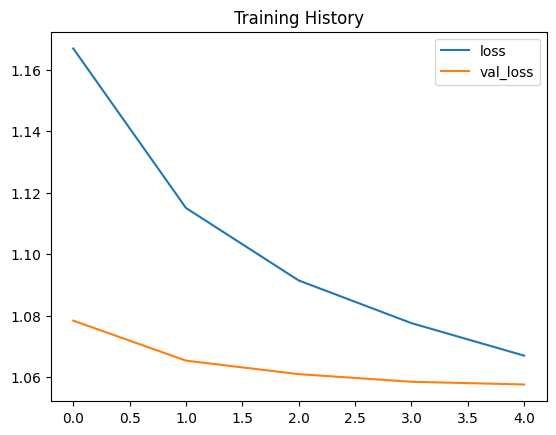

In [10]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.weights.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
]

# Train model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot training history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Training History")
plt.show()

## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">7. Prediction & Submission</div>

In [11]:
# Generate predictions
test_preds = model.predict(test_ds)
test_df['prediction'] = np.argmax(test_preds, axis=1)

# Create submission
submission = pd.DataFrame({
            "id": test_df.id,
            "winner_model_a": test_preds[:, 0],
            "winner_model_b": test_preds[:, 1],
            "winner_tie": test_preds[:, 2]
        })
submission.to_csv("submission.csv", index=False)
print("Submission saved!")
submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Submission saved!


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.287083,0.318797,0.394119
1,211333,0.401011,0.328618,0.270371
2,1233961,0.387071,0.326522,0.286407
